In [1]:
from qpe import *
from numpy import log

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde
from scipy.integrate import quad

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rc('text', usetex=True)

In [2]:
def aux_info_exact(pars, a, b, channel_func, channel_args, prior_func, prior_args, dm_ini, n_layers, labels, n_copies=1, n_meas=0, dp=1e-5):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations. """

    n_inp = int(log2(len(dm_ini)))
    n_tot = n_inp*n_copies
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    U = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [U.conj().T@proj@U for proj in projs]
    H = sum([x*proj for x, proj in zip(pars_est, projs_u)])

    ### calculations for tha van Trees inequality; unused ###
    # def func_F(phi):
    #     CFI = cfi(channel_func, dm_ini, phi, channel_args, projs_u, n_copies=n_copies, n_ext=0, dp=dp)
    #     return CFI*prior_func(phi, *prior_args)
    # def func_I(phi):
    #     prior_der = (prior_func(phi + dp, *prior_args) - prior_func(phi - dp, *prior_args))/(2*dp)
    #     return prior_der**2/prior_func(phi, *prior_args)

    # int_F = quad(func_F, a, b)[0]
    # int_I = quad(func_I, a, b)[0]
    # CRB = 1/(int_F + int_I)

    dms = []
    dms_der = []
    for p in labels:
        dm = reduce(kron, [channel_func(dm_ini, p, *channel_args)]*n_copies)
        dm_p = reduce(kron, [channel_func(dm_ini, p+dp, *channel_args)]*n_copies)
        dm_m = reduce(kron, [channel_func(dm_ini, p-dp, *channel_args)]*n_copies)
        dm_der = (dm_p - dm_m)/(2*dp)
        dms.append(dm)
        dms_der.append(dm_der)

    expecs = []
    expecs_der = []
    disps = []
    for j in range(len(labels)): # take a density matrix from the training set
        probs = [trace(dms[j]@proj).real for proj in projs_u]
        probs_der = [trace(dms_der[j]@proj).real for proj in projs_u]
        expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
        expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
        disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
    
    return array(expecs), array(expecs_der), array(disps)#, CRB, int_F, int_I, H

In [3]:
def train_bayes_exact(n_layers, a, b, prior_func, prior_args=[], n_copies=1, n_meas=0, method="BFGS", x0=None, options={}):

    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot
        
    if n_meas == 0:
        n_meas = n_tot
    n_pars_est = 2**n_meas
    n_pars_ans = (3*n_tot - 1)*n_layers + 2*n_tot # cry  
    
    d_diff = 0 if n_tot == n_meas else 2**(n_tot - n_meas)
    
    dms_cop = [reduce(kron, [dm]*n_copies) for dm in dms]

    def fun_int(phi, x_est, U):
        dm = channel_func(dm_ini, phi, *channel_args)
        dm = reduce(kron, [dm]*n_copies)
        dm_u = U@dm@U.conj().T
        probs = dm_u.diagonal().real
        return np.sum((x_est - phi)**2*probs*prior_func(phi, *prior_args))
    
    fvals = []
    fval_cont = [0]
    def fun(x):
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        U = hea_cry_rzrx(n_tot, n_layers, x_ans)
        f = quad(fun_int, a, b, args=(x_est, U))[0]
        fval_cont[0] = f
        return f
        
    def callback(x):
        fvals.append(fval_cont[0])
        print("Iteration: %d | Function value: %.8f" %(len(fvals), fval_cont[0]), end="\r")
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, pi)]*n_pars_ans + [(-10, 10)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi, 0.01*pi, n_pars_ans)
        x0_est = normal(0, 0.01, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)

    return fvals, optimization_result

# Single copy

In [4]:
# channel_func = generalized_amplitude_damping_channel; channel_args = [0, 0]; channel_name = "ad"
# channel_func = z_rot; channel_args = [0]; channel_name = "zrot"
channel_func = depolarizing_channel; channel_args = []; channel_name = "depolarizing"

# sv_ini = array(rand_ket(2))
# dm_ini = outer(sv_ini, sv_ini.conj().T)
# dm_ini = array(qp.rand_dm_hs(2))
# dm_ini = eye(2)/2
dm_ini = (eye(2) + X)/2
# dm_ini = (eye(2) + Z)/2

In [24]:
a = 0 + 1e-3
b = 4/3 - 1e-3
T = 15

labels = linspace(a, b, T)#[1:-1]
dms = [channel_func(dm_ini, p, *channel_args) for p in labels]

In [25]:
method = "BFGS"
n_copies = 1
n_inp = int(log2(len(dm_ini)))
n_meas = n_inp*n_copies
n_layers = 1

dp = 1e-5

dphi = 1/sqrt(2)
prior_func = lambda p: 1/(b - a); prior_args = []
# prior_func = lambda phi: exp(-(phi**2)/(2*dphi)**2)/sqrt(2*pi*dphi**2); prior_args = []

x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)])

fvals, result = train_bayes_exact(n_layers, a, b, prior_func, prior_args, n_copies=n_copies, n_meas=n_meas, method=method, x0=x0, options={})
pars = result.x

print("\n", result.message)

Iteration: 16 | Function value: 0.12316049
 Optimization terminated successfully.


In [26]:
expecs, expecs_der, disps = aux_info_exact(pars, a, b, channel_func, channel_args, prior_func, prior_args, dm_ini, n_layers, labels, n_copies=n_copies, n_meas=n_meas, dp=dp)

n_inp: 1 | n_copies: 1 | n_meas: 1 | n_layers: 1 


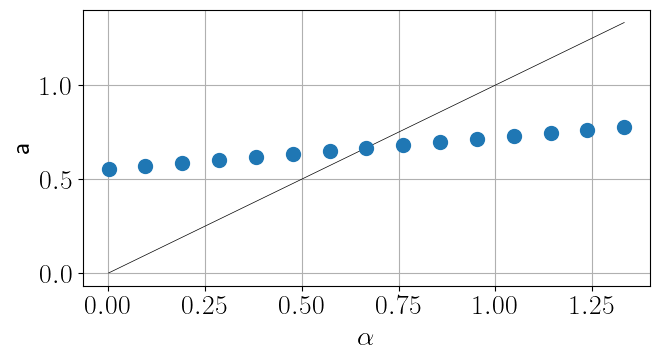

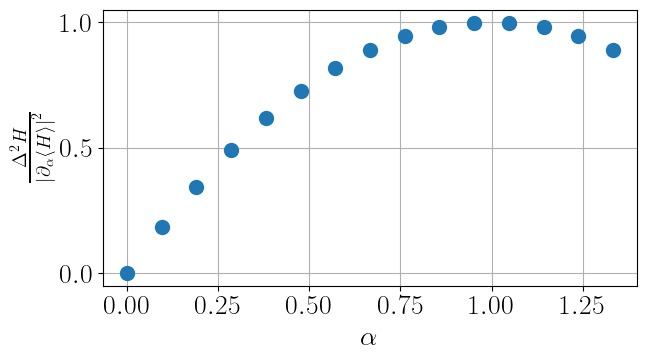

In [27]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas, n_layers))

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
# plt.plot(labels, expecs, zorder=10)
plt.scatter(labels, expecs, s=100, zorder=10)
plt.plot(labels, labels, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\mathsf{a}$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
# plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels, disps/expecs_der**2, s=100, zorder=10)
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
# plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
# plt.yscale("log")
plt.show()

In [28]:
expecs

array([0.55605631, 0.57185782, 0.58765934, 0.60346085, 0.61926236,
       0.63506388, 0.65086539, 0.66666691, 0.68246842, 0.69826994,
       0.71407145, 0.72987297, 0.74567448, 0.761476  , 0.77727751])

In [29]:
expecs_der

array([0.16616515, 0.16616515, 0.16616515, 0.16616515, 0.16616515,
       0.16616515, 0.16616515, 0.16616515, 0.16616515, 0.16616515,
       0.16616515, 0.16616515, 0.16616515, 0.16616515, 0.16616515])

In [30]:
disps

array([5.51942524e-05, 5.05157715e-03, 9.54858432e-03, 1.35462158e-02,
       1.70444715e-02, 2.00433515e-02, 2.25428558e-02, 2.45429843e-02,
       2.60437372e-02, 2.70451143e-02, 2.75471157e-02, 2.75497413e-02,
       2.70529913e-02, 2.60568655e-02, 2.45613640e-02])

In [12]:
### calculations for tha van Trees inequality; unused ###

# method = "BFGS"
# n_copies = 1
# n_inp = int(log2(len(dm_ini)))
# n_meas = n_inp*n_copies
# n_layers = 1

# dp = 1e-2
# x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)])
# prior_func = lambda phi, dphi: exp(-(phi**2)/(2*dphi)**2)/sqrt(2*pi*dphi**2); prior_args = [dphi]

# a = -pi - 1e-2
# b = pi + 1e-2
# dphi_list = linspace(0.075, 1, 20)
# mse_list = []
# CRB_list = []
# int_F_list = []
# int_I_list = []
# for dphi in dphi_list:
#     print(dphi)
#     print()
#     prior_args = [dphi]
#     fvals, result = train_bayes_exact(n_layers, a, b, prior_func, prior_args, n_copies=n_copies, n_meas=n_meas, method=method, x0=x0, options={})
#     pars = result.x
#     expecs, expecs_der, disps, CRB, int_F, int_I, H = aux_info_exact(pars, a, b, channel_func, channel_args, prior_func, prior_args, dm_ini, n_layers, labels, n_copies=n_copies, n_meas=n_meas, dp=dp)
#     mse_list.append(result.fun)
#     CRB_list.append(CRB)
#     int_F_list.append(int_F)
#     int_I_list.append(int_I)
#     print()